April 7, 2025 ToDo:
* Change the search to be based on the caldera geometry for ascending burst IDs for the four bursts of interest over the southeast portion of the island
    * Use asf_search for this
* Mosaic and process the interferograms for these bursts to compare
* Clip the sample visualizations to be to these four mosaic'd bursts
* Transfer some of the helper functions to a separate module (not as pressing)

In [76]:
#!pip install opera-utils

In [12]:
import opera_utils
import asf_search
import xarray as xr
import pandas as pd
import geopandas as gpd
from shapely.geometry import box
import numpy as np
import h5py
from fft_unwrap import unwrap_phase_fft
import matplotlib.pyplot as plt
from matplotlib.patches import Patch
from matplotlib_scalebar.scalebar import ScaleBar
import contextily as ctx
import h5py
from pathlib import Path
from shapely.geometry import Polygon
from shapely import wkt
import os
import glob

Here, we'll inspect some OPERA DISP-S1 sample products over Kilauea produced from March - May 2018.

https://www.nps.gov/havo/learn/nature/2018-eruption.htm

S1 bursts of interest:

Asc:
- T124_264305_IW2
- T124_264306_IW2
- T124_264305_IW3 
- T124_264306_IW3 

Desc:
- T087_185682_IW1
- T087_185683_IW1
- T087_185682_IW2
- T087_185683_IW2

In [3]:
asc_list = [
    'T124_264305_IW2',
    'T124_264306_IW2',
    'T124_264305_IW3',
    'T124_264306_IW3'
]
desc_list = [
    'T087_185682_IW1',
    'T087_185683_IW1',
    'T087_185682_IW2',
    'T087_185683_IW2'
]
parms = {
        'dataset':asf_search.DATASET.OPERA_S1,
        'processingLevel':asf_search.PRODUCT_TYPE.CSLC,
        'operaBurstID':asc_list,
        'start':'2018-03-01T00:00:00Z',
        'end':'2018-05-31T00:00:00Z',
        'flightDirection':asf_search.FLIGHT_DIRECTION.ASCENDING,
        'maxResults':100,
}

In [6]:
asc_burst_items = asf_search.search(**parms)
len(asc_burst_items)

44

In [7]:
asc_urls = [url for item in asc_burst_items for url in [item.properties['url']]]
asf_search.download_urls(urls=asc_urls, path='/home/jehayes/sar_dump/opera_cslc/asc')

In [8]:
parms.update({
     'operaBurstID': desc_list,
     'flightDirection': asf_search.FLIGHT_DIRECTION.DESCENDING
 })
desc_burst_items = asf_search.search(**parms)
print(len(desc_burst_items))
desc_urls = [url for item in desc_burst_items for url in [item.properties['url']]]
asf_search.download_urls(urls=desc_urls, path='/home/jehayes/sar_dump/opera_cslc/desc')

40


In [14]:
# we processed samples for the frame id 33039
# since this frame id overlaps with our burst id of interest
# we see that frame id 33038 also overlaps with our bursts, but there are no samples available for that frame id

# find matching files for burst IDs
def find_matching_files(burst_list, directory):
    matching_files = []
    for burst_id in burst_list:
        search_pattern = burst_id.replace('_', '-')
        found_files = glob.glob(os.path.join(directory, f"*{search_pattern}*.h5"))
        if found_files: matching_files.append(found_files[0])
        else: print(f"No file found for burst ID: {burst_id}")
    return matching_files[:4]  # Return up to 4 files

# get burst info from file
def get_burst_info(filename):
    with h5py.File(filename, 'r') as f:
        return f['identification/burst_id'][()]

# display burst information
def process_burst_files(files, direction):
    if not files:
        print(f"No matching {direction} files found.")
        return
 
    files_to_use = [files[min(i, len(files)-1)] for i in range(4)]
    
    burst_ids = [get_burst_info(f) for f in files_to_use]
    frame_ids = [opera_utils.get_frame_ids_for_burst(bid.decode()) for bid in burst_ids]

    for i, (bid, fid) in enumerate(zip(burst_ids, frame_ids)):
        print(f"{direction.capitalize()} burst ID {i+1}: {bid}")
        print(f"{direction.capitalize()} frame IDs {i+1}: {fid}")
    
    return burst_ids, frame_ids, files_to_use

# ascending bursts
asc_files = find_matching_files(asc_list, "/home/jehayes/sar_dump/opera_cslc/asc")
asc_burst_ids, asc_frame_ids, asc_files_used = process_burst_files(asc_files, "ascending")

# descending bursts
desc_files = find_matching_files(desc_list, "/home/jehayes/sar_dump/opera_cslc/desc")
desc_burst_ids, desc_frame_ids, desc_files_used = process_burst_files(desc_files, "descending")

print("NOTE: We processed samples for frame ID 33039 since frame ID 23211 does not have any samples, so only ascending data.")

Ascending burst ID 1: b't124_264305_iw2'
Ascending frame IDs 1: [33038, 33039]
Ascending burst ID 2: b't124_264306_iw2'
Ascending frame IDs 2: [33039]
Ascending burst ID 3: b't124_264305_iw3'
Ascending frame IDs 3: [33038, 33039]
Ascending burst ID 4: b't124_264306_iw3'
Ascending frame IDs 4: [33039]
Descending burst ID 1: b't087_185682_iw1'
Descending frame IDs 1: [23211]
Descending burst ID 2: b't087_185683_iw1'
Descending frame IDs 2: [23211]
Descending burst ID 3: b't087_185682_iw2'
Descending frame IDs 3: [23211]
Descending burst ID 4: b't087_185683_iw2'
Descending frame IDs 4: [23211]
NOTE: We processed samples for frame ID 33039 since frame ID 23211 does not have any samples, so only ascending data.


In [15]:
asc_files_used

['/home/jehayes/sar_dump/opera_cslc/asc/OPERA_L2_CSLC-S1_T124-264305-IW2_20180420T043041Z_20240429T081305Z_S1A_VV_v1.1.h5',
 '/home/jehayes/sar_dump/opera_cslc/asc/OPERA_L2_CSLC-S1_T124-264306-IW2_20180315T043042Z_20240428T220102Z_S1A_VV_v1.1.h5',
 '/home/jehayes/sar_dump/opera_cslc/asc/OPERA_L2_CSLC-S1_T124-264305-IW3_20180420T043041Z_20240429T081305Z_S1A_VV_v1.1.h5',
 '/home/jehayes/sar_dump/opera_cslc/asc/OPERA_L2_CSLC-S1_T124-264306-IW3_20180408T043044Z_20240429T045313Z_S1A_VV_v1.1.h5']

In [17]:
def get_burst_footprint(filename):
    """Extract the burst footprint from an OPERA CSLC-S1 product"""
    with h5py.File(filename, 'r') as f:
        if 'identification/bounding_polygon' in f:
            wkt_str = f['identification/bounding_polygon'][()].decode('utf-8')
            polygon = wkt.loads(wkt_str)
            orbit_dir = f['identification/orbit_pass_direction'][()].decode('utf-8')
            if 'data/projection' in f:
                crs = f['data/projection'][()]
            else:
                # Default to WGS84 if not specified
                crs = 'EPSG:4326'
                
            return {'orbit': orbit_dir, 'geometry': polygon, 'crs': crs}
        else:
            return None

def get_burst_data(file_path):
    burst_id = get_burst_info(file_path).decode()
    footprint = get_burst_footprint(file_path)
    if footprint:
        return {'burst_id': burst_id, 'geometry': footprint['geometry']}
    else:
        return {'burst_id': burst_id, 'geometry': None}

burst_data = [get_burst_data(file) for file in asc_files_used]
gf_cslc_bursts = gpd.GeoDataFrame(burst_data, crs="EPSG:4326")

In [18]:
# TODO: get the frame_id in a better, more-intuitive way
def get_xarray_footprint(da):
    """Extract the footprint polygon from an xarray DataArray."""
    mask = ~np.isnan(da.values)
    
    x_coords, y_coords = da.x.values, da.y.values
    xx, yy = np.meshgrid(x_coords, y_coords)

    from skimage import measure
    contours = measure.find_contours(mask, 0.5)
    boundary = contours[0]

    poly_coords = [(xx[int(y), int(x)], yy[int(y), int(x)]) for y, x in boundary]
    
    return Polygon(poly_coords)

fn_east_los = '/home/jehayes/opera_disp_samples/kil_2018_04/geometry/los_east.tif'
ds_east_los = xr.open_dataset(fn_east_los)

gf_frame = gpd.GeoDataFrame(
    {'source': ['xarray_dataset']},
    geometry=[get_xarray_footprint(ds_east_los.band_data.squeeze())],
    crs=ds_east_los.rio.crs
)

In [27]:
# Kilauea caldera coordinates
kilauea_lat, kilauea_lon = 19.4069, -155.2834
from pyproj import Transformer
transformer = Transformer.from_crs("EPSG:4326", gf_frame.crs, always_xy=True)
kilauea_x, kilauea_y = transformer.transform(kilauea_lon, kilauea_lat)

In [25]:
gf_cslc_bursts = gf_cslc_bursts.to_crs(gf_frame.crs)

/tmp/ipykernel_38110/3928378982.py:6: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  pastel2 = get_cmap('Pastel2')


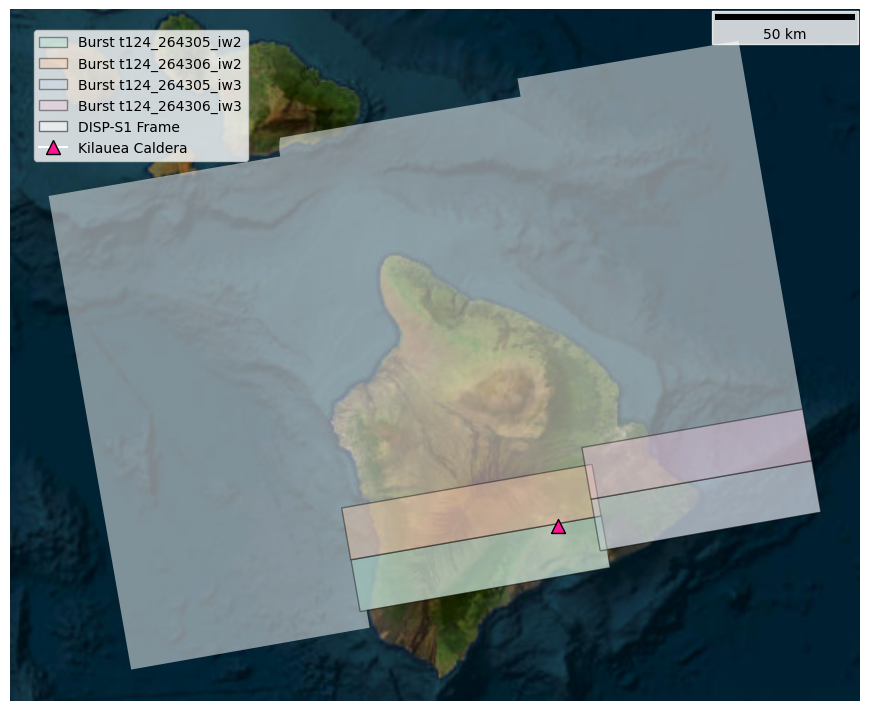

In [29]:
from matplotlib.cm import get_cmap
from matplotlib.lines import Line2D

f, ax = plt.subplots(figsize=(14, 7), layout='constrained')

pastel2 = get_cmap('Pastel2')
colors = [pastel2(i) for i in range(len(gf_cslc_bursts))]

gf_frame.plot(ax=ax, color="white", alpha=0.5)

for i, (idx, row) in enumerate(gf_cslc_bursts.iterrows()):
    color = colors[i]
    temp_gdf = gpd.GeoDataFrame(geometry=[row.geometry], crs=gf_cslc_bursts.crs)
    temp_gdf.plot(ax=ax, facecolor=color, edgecolor='black', alpha=0.4)

ax.scatter(kilauea_x, kilauea_y,
           marker='^',
           s=100,
           color='deeppink',
           edgecolor='black',
           zorder=10,
           label='Kilauea Caldera')

ctx.add_basemap(ax=ax, crs=gf_cslc_bursts.crs,
                source=ctx.providers.Esri.WorldImagery,
                attribution=False)

burst_patches = []
for i, (idx, row) in enumerate(gf_cslc_bursts.iterrows()):
    burst_id = row['burst_id']
    color = colors[i]
    burst_patches.append(Patch(facecolor=color, edgecolor='black', alpha=0.4,
                              label=f'Burst {burst_id}'))
frame_patch = Patch(facecolor='white', edgecolor='black', alpha=0.5, label='DISP-S1 Frame')
kilauea_marker = Line2D([0], [0], marker='^', color='w', markerfacecolor='deeppink',
                        markeredgecolor='black', markersize=10, label='Kilauea Caldera')
legend_elements = burst_patches + [frame_patch, kilauea_marker]
legend = ax.legend(handles=legend_elements,
                  loc='upper left',
                  bbox_to_anchor=(0.02, 0.98),
                  framealpha=0.8,
                  facecolor='white',
                  fontsize=10)

scalebar = ScaleBar(1, "m", box_alpha=0.8, location='upper right')

ax.add_artist(scalebar)
ax.set(xticks=[], yticks=[],
       xlabel="", ylabel="",
       frame_on=False)
plt.show()

These sample products are not released yet, so I cannot the code that produced them, but we will inspect them below

In [4]:
dir_base = Path('/home/jehayes/opera_disp_samples/kil_2018_04')
for item in dir_base.iterdir():
    if item.is_dir():
        print(item)

/home/jehayes/opera_disp_samples/kil_2018_04/mintpy_output
/home/jehayes/opera_disp_samples/kil_2018_04/data
/home/jehayes/opera_disp_samples/kil_2018_04/geometry
/home/jehayes/opera_disp_samples/kil_2018_04/static_lyrs


Burst info and extent

In [ ]:
static_dir = dir_base / 'static_lyrs'
burst_ids = []
geometries = []
orbit_directions = []
filenames = []
for file_path in static_dir.glob('*.h5'):
    burst_id = get_burst_info(file_path)
    footprint_info = get_burst_footprint(file_path)
    if burst_id and footprint_info:
        burst_ids.append(burst_id.decode())
        geometries.append(footprint_info['geometry'])
        orbit_directions.append(footprint_info['orbit'])
        filenames.append(file_path.name)
if burst_ids:
    gdf_all_bursts = gpd.GeoDataFrame(
        {
            'burst_id': burst_ids,
            'orbit': orbit_directions,
            'filename': filenames
        },
        geometry=geometries,
        crs='EPSG:4326'
    )
    print(f"\nFound {len(gdf_all_bursts)} burst footprints")
else:
    print("No valid burst footprints found")


Found 27 burst footprints


In [84]:
gdf_all_bursts.explore(column='burst_id', popups=True)

Geometry

In [122]:
geom_dir = dir_base / 'geometry'
fn_height = geom_dir / 'height.tif'
fn_layover = geom_dir / 'layover_shadow_mask.tif'
los_east = geom_dir / 'los_east.tif'
fn_los_north = geom_dir / 'los_north.tif'

da_height = xr.open_dataarray(fn_height).squeeze()
da_layover = xr.open_dataarray(fn_layover).squeeze()
da_los_east = xr.open_dataarray(los_east).squeeze()
da_los_north = xr.open_dataarray(fn_los_north).squeeze()

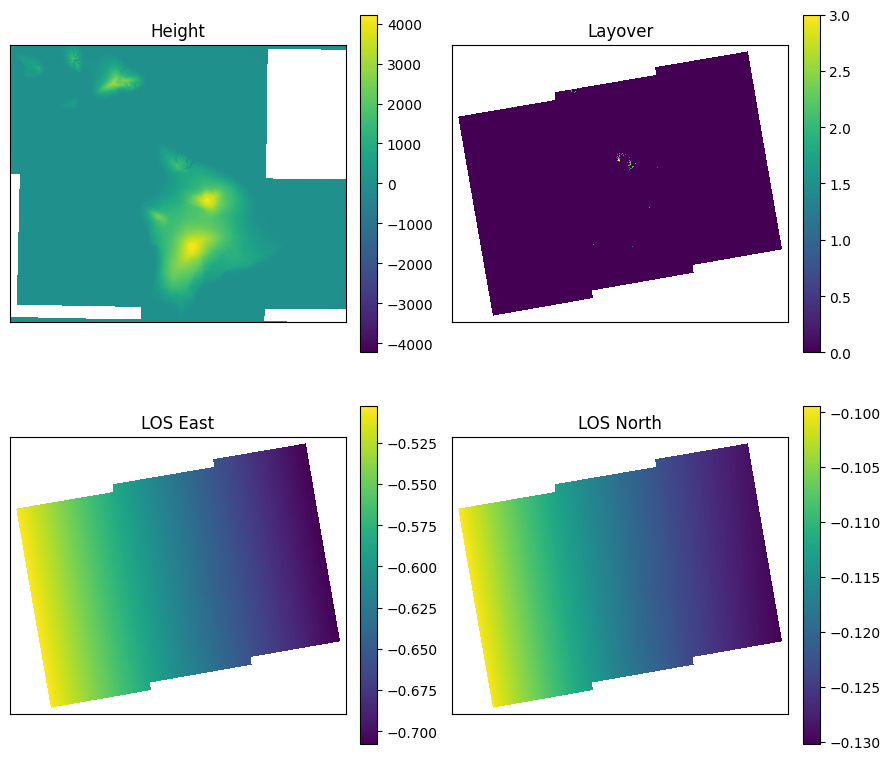

In [128]:
fig, axes = plt.subplots(2, 2, figsize=(9,8), sharex=True, sharey=True)
axes = axes.flatten()

data_arrays = [da_height, da_layover, da_los_east, da_los_north]
titles = ['Height', 'Layover', 'LOS East', 'LOS North']

for i, (da, title) in enumerate(zip(data_arrays, titles)):
    im = da.plot.imshow(
        ax=axes[i],
        cmap='viridis',
        add_colorbar=False
    )
    cbar = fig.colorbar(im, ax=axes[i], fraction=0.046, pad=0.04)
    axes[i].set(xticks=[], yticks=[], xlabel="", ylabel="")
    axes[i].set_title(title)
    axes[i].set_aspect('equal')

plt.tight_layout()
plt.show()

More Contextual Data

In [131]:
mintpy_dir = dir_base / 'mintpy_output'
fn_lulc = mintpy_dir / 'esa_world_cover_2021_mask.tif'
fn_dem = mintpy_dir / 'glo_30_DEM.tif'
fn_mask = mintpy_dir / 'recommended_mask.h5'
fn_mask_thresh = mintpy_dir / 'recommended_mask_90thresh.h5'
fn_geom_geo = mintpy_dir / 'geometryGeo.h5'

fn_spat_coh = mintpy_dir / 'avg_lyrs' / 'estimatedSpatialCoherence.h5'
fn_temp_coh = mintpy_dir / 'avg_lyrs' / 'temporalCoherence.h5'

da_lulc_mask = xr.open_dataarray(fn_lulc).squeeze()
da_dem = xr.open_dataarray(fn_dem).squeeze()

ds_mask = xr.open_dataset(fn_mask).squeeze()
ds_mask_thresh = xr.open_dataset(fn_mask_thresh).squeeze()
ds_geom_geo = xr.open_dataset(fn_geom_geo).squeeze()
da_spat_coh = xr.open_dataarray(fn_spat_coh).squeeze()
da_temp_coh = xr.open_dataarray(fn_temp_coh).squeeze()

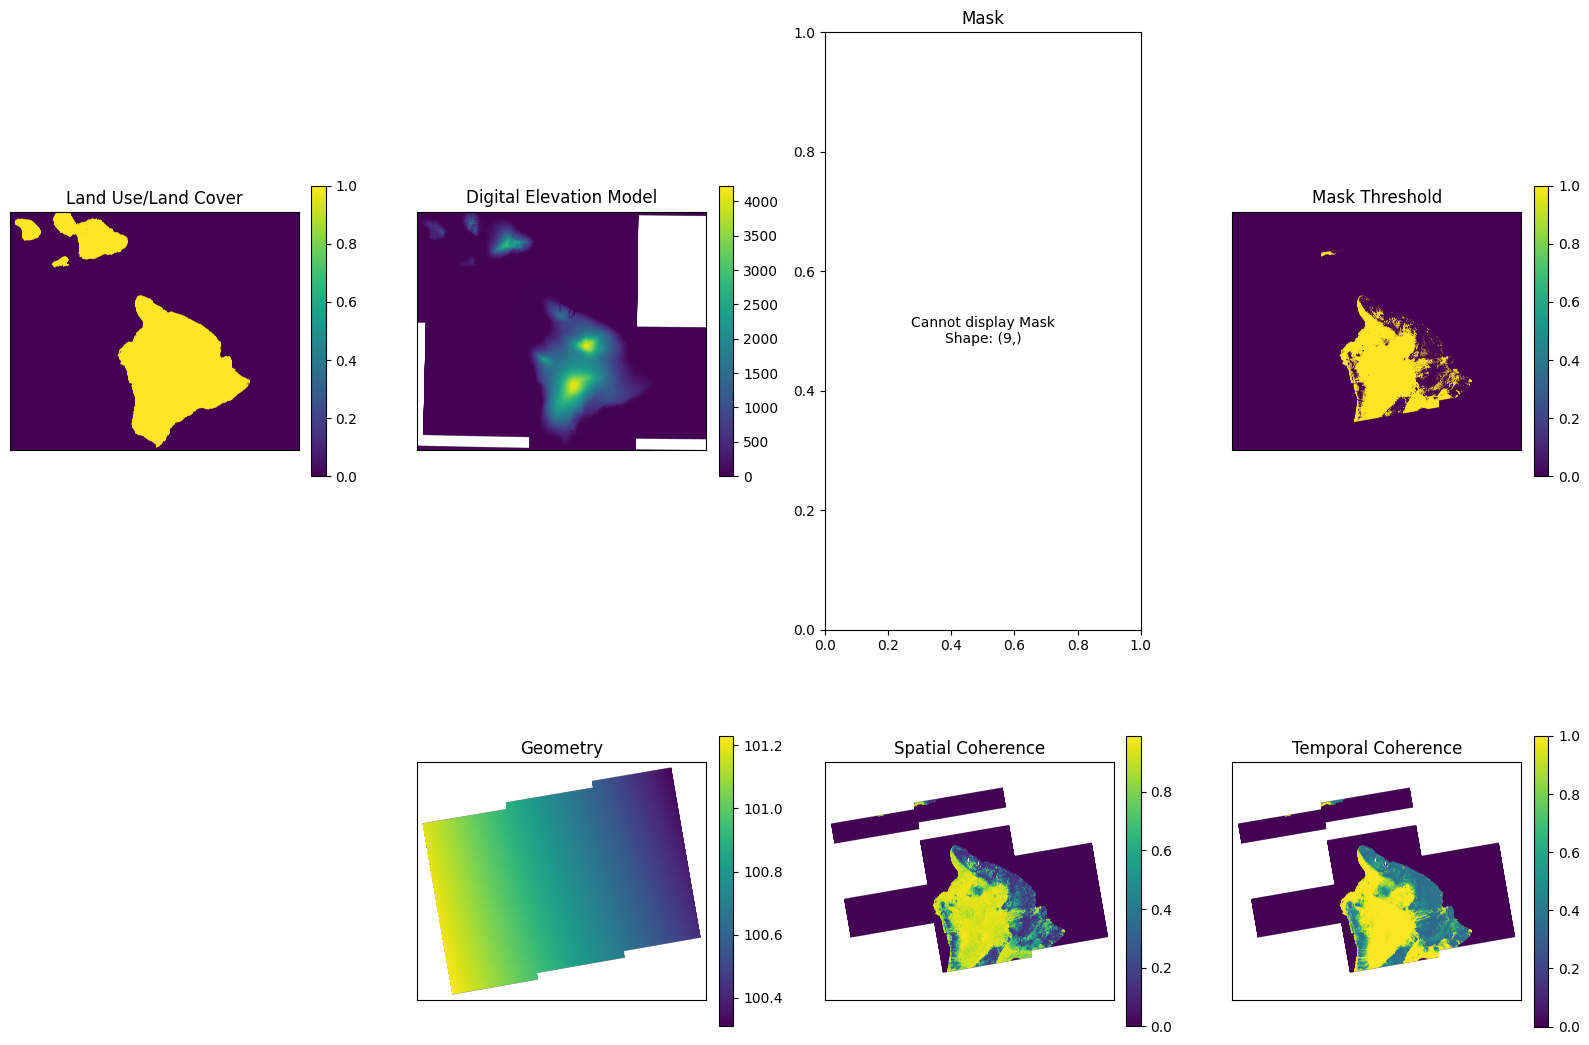

In [134]:
import matplotlib.gridspec as gridspec

fig = plt.figure(figsize=(16, 12))
gs = gridspec.GridSpec(2, 4, height_ratios=[1, 1])

axes = []
# Top row - 4 plots
for i in range(4):
    axes.append(plt.subplot(gs[0, i]))
# Bottom row - 3 plots
for i in range(3):
    axes.append(plt.subplot(gs[1, i+1]))  # +1 to center the plots

data_arrays = [
    da_lulc_mask,
    da_dem,
    ds_mask,
    ds_mask_thresh,
    ds_geom_geo,
    da_spat_coh,
    da_temp_coh
]

titles = [
    'Land Use/Land Cover',
    'Digital Elevation Model',
    'Mask',
    'Mask Threshold',
    'Geometry',
    'Spatial Coherence',
    'Temporal Coherence'
]

for i, (da, title) in enumerate(zip(data_arrays, titles)):
    if hasattr(da, 'data_vars'):
        var_name = list(da.data_vars)[0]
        da = da[var_name]
    data = da.values
    
    # Check if the data is suitable for imshow (must be 2D)
    if len(data.shape) != 2:
        print(f"Warning: {title} has shape {data.shape}, which is not 2D. Skipping or handling differently.")

        axes[i].text(0.5, 0.5, f"Cannot display {title}\nShape: {data.shape}", 
                    ha='center', va='center', transform=axes[i].transAxes)
        axes[i].set_title(title)

        continue
    # For 2D data, use imshow
    im = axes[i].imshow(data, cmap='viridis')
    cbar = fig.colorbar(im, ax=axes[i], fraction=0.046, pad=0.04)
    axes[i].set(xticks=[], yticks=[], xlabel="", ylabel="")
    axes[i].set_title(title)
    axes[i].set_aspect('equal')

plt.tight_layout()
plt.show()

Timeseries output

In [91]:
fn_veolcity = mintpy_dir / 'velocity.tif'
ds_velocity = xr.open_dataset(fn_veolcity)

In [104]:
ds_velocity

<xarray.Dataset> Size: 300MB
Dimensions:      (band: 1, x: 9525, y: 7870)
Coordinates:
  * band         (band) int64 8B 1
  * x            (x) float64 76kB 7.294e+04 7.298e+04 ... 3.586e+05 3.587e+05
  * y            (y) float64 63kB 2.327e+06 2.327e+06 ... 2.091e+06 2.091e+06
    spatial_ref  int64 8B ...
Data variables:
    band_data    (band, y, x) float32 300MB ...

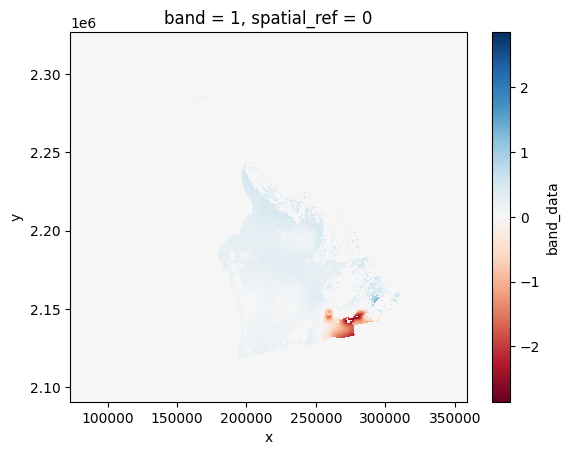

In [88]:
ds_velocity.band_data.squeeze().plot.imshow(cmap="RdBu");

In [115]:
np.nanmin(ds_velocity.band_data.squeeze()), np.nanmax(ds_velocity.band_data.squeeze())

(np.float32(-2.854347), np.float32(1.5386692))

In [100]:
fn_timeseries = mintpy_dir / 'timeseries.h5'
ds_timeseries = xr.open_dataset(fn_timeseries)

In [103]:
ds_timeseries.timeseries

<xarray.DataArray 'timeseries' (phony_dim_1: 9, phony_dim_2: 7870,
                                phony_dim_3: 9525)> Size: 3GB
[674655750 values with dtype=float32]
Dimensions without coordinates: phony_dim_1, phony_dim_2, phony_dim_3

In [ ]:
# TODO: why below upside down, can't figure out how to flip axes, oops

/tmp/ipykernel_267178/469393235.py:29: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


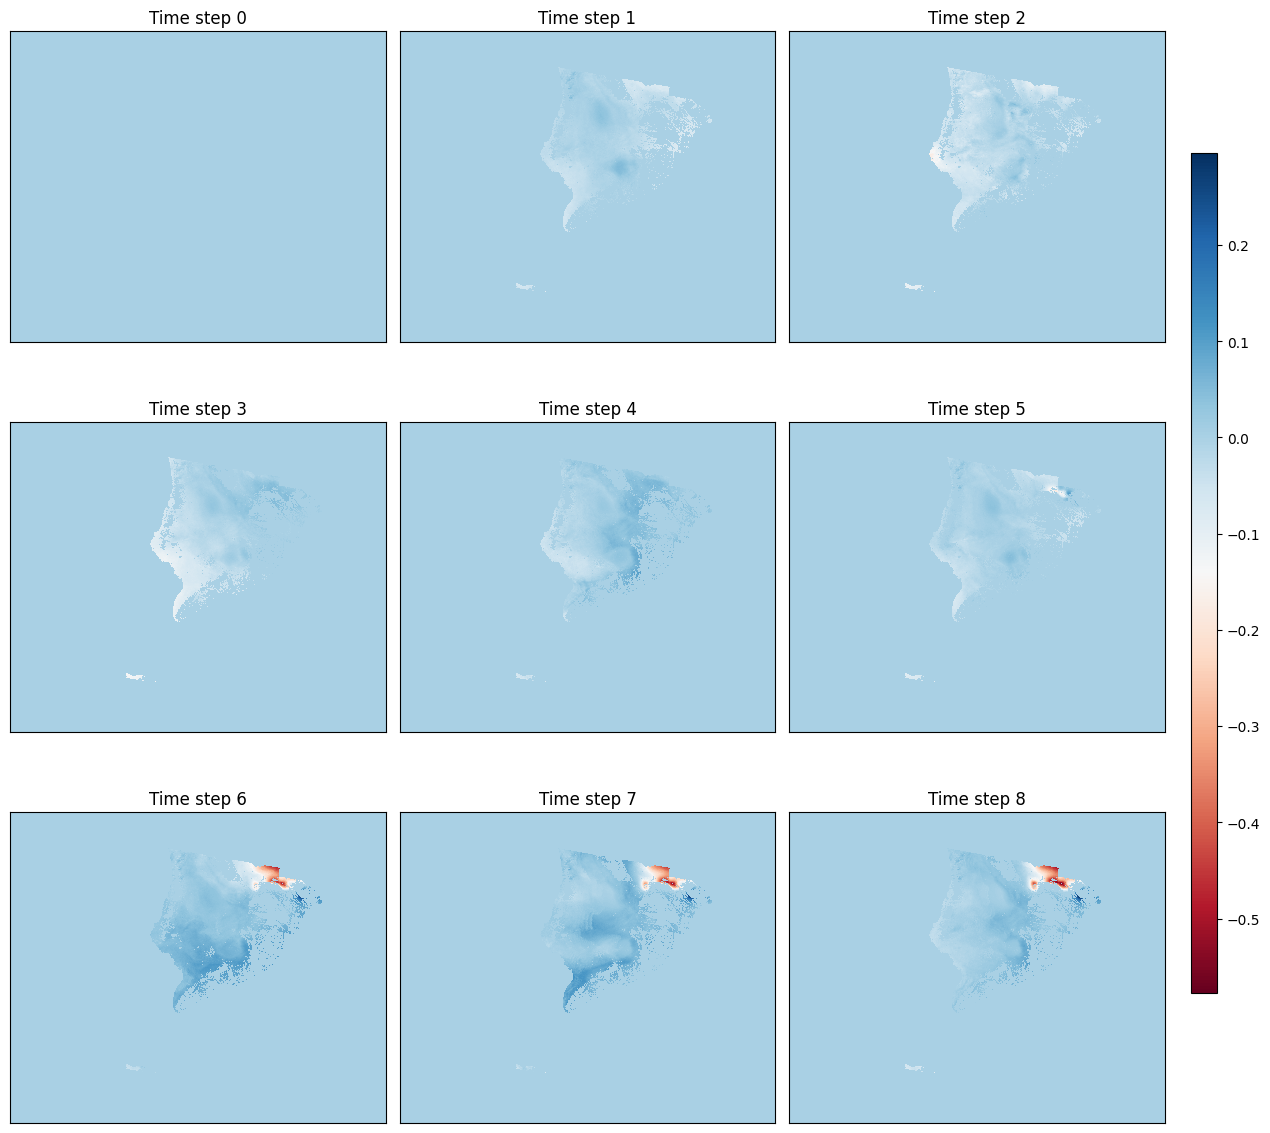

In [129]:
fig, axes = plt.subplots(3, 3, figsize=(13, 12), sharex=True, sharey=True)
axes = axes.flatten()

vmin = np.nanmin(ds_timeseries.timeseries.values)
vmax = np.nanmax(ds_timeseries.timeseries.values)

for i in range(9):
    time_slice = ds_timeseries.timeseries.isel(phony_dim_1=i)
    
    # origin='lower' to fix the axis orientation
    im = time_slice.plot.imshow(
        ax=axes[i],
        cmap="RdBu",
        vmin=vmin,
        vmax=vmax,
        add_colorbar=False,
        origin='lower' 
    )

    axes[i].set(xticks=[], yticks=[],
       xlabel="", ylabel="")
    
    axes[i].set_title(f"Time step {i}")
    axes[i].set_aspect('equal')

cbar_ax = fig.add_axes([0.92, 0.15, 0.02, 0.7])
fig.colorbar(im, cax=cbar_ax)

plt.tight_layout()
plt.subplots_adjust(right=0.9)
plt.show()

---

## Interferometry steps from NASA CSLCs

Each pixel in a complex SAR image contains both amplitude and phase information:​

* **Amplitude**: Reflects the strength of the radar return signal, indicating how much energy was backscattered from the surface.​
* **Phase**: Represents the position of the wave cycle at the time of measurement, which is related to the distance between the sensor and the target on the ground.

### 1. Calculating the Interferogram:

To compute an interferogram, we multiply each pixel of the reference SAR image $S_1$ by the complex conjugate of the corresponding pixel in the secondary SAR image $S_2$:

$$ \text{Interferogram} = S_1 \times S_2^* $$

#### What this operation entails:

- **Complex Conjugate $S_2^*$**: This involves inverting the sign of the imaginary component of $S_2$. If a pixel value in $S_2$ is represented as $a + bi$ (where $a$ is the real part and $bi$ is the imaginary part), its complex conjugate is $a - bi$.

- **Multiplication**: By multiplying $S_1$ by $S_2^*$, the amplitudes are combined, and the phases are subtracted:

$$ (a_1 + b_1 i) \times (a_2 - b_2 i) = (a_1 a_2 + b_1 b_2) + (b_1 a_2 - a_1 b_2) i $$

This operation results in a new complex value for each pixel, where the **phase** component represents the difference in phase between the two original images. This phase difference corresponds to changes in the distance between the ground and the radar sensor between the two acquisition times, which can be due to ground displacement, topography, or atmospheric effects.

* The real part ($a$) represents the in-phase component of the backscattered signal
* The imaginary part ($bi$) represents the quadrature (or out-of-phase) component

Together, they encode both the amplitude and phase of the radar return

#### Extracting the Phase (Wrapped Phase):

The interferogram contains complex values, but for many applications, we are primarily interested in the **phase** information. The `np.angle` function is used to extract the **phase angle** (in radians) from each complex value, resulting in the "wrapped phase". This phase is constrained between $-\pi$ and $\pi$ and represents the modulo $2\pi$ phase difference between the two images.

- **Mathematically**, the `np.angle` function computes the phase $\theta$ of a complex number $z = a + bi$ as:

$$ \theta = \arg(z) = \tan^{-1}\left( \frac{b}{a} \right) $$

Where $\arg(z)$ is the angle of the complex number $z$ with respect to the positive real axis.

​In InSAR, the phase angle extracted from the interferogram indicates the difference in radar signal phase between two acquisitions, reflecting surface displacement. To accurately determine this angle, $\tan^{-1}$ computes the arctangent of the ratio of the imaginary to the real part of a complex number, considering their signs to place the angle in the correct quadrant. 

The "quadrant" relates directly to the Line of Sight (LOS) deformation:

In the context of SAR interferometry, the quadrant represents the direction of ground movement relative to the radar sensor. The four quadrants correspond to different LOS displacement scenarios:

- Positive phase (moving towards the sensor)
- Negative phase (moving away from the sensor)
- Minimal or no movement
- Complex displacement patterns

The phase angle calculation 

$$ \tan^{-1}\left( \frac{b}{a} \right) $$

determines the precise location within these quadrants by considering:

- The sign of the real part ($a$)
- The sign of the imaginary part ($b$)

## Extracting the Phase (Wrapped Phase):

The interferogram contains complex values, but for many applications, we are primarily interested in the phase information. The `np.angle` function is used to extract the phase angle (in radians) from each complex value, resulting in the "wrapped phase". This phase is constrained between $-\pi$ and $\pi$ and represents the modulo $2\pi$ phase difference between the two images.

## Quadrant Correction Method:

- If $a > 0$: Standard arctangent calculation
- If $a < 0$ and $b \geq 0$: Add $\pi$ to the result
- If $a < 0$ and $b < 0$: Subtract $\pi$ from the result
- If $a = 0$:
  - $b > 0$: $\frac{\pi}{2}$
  - $b < 0$: $-\frac{\pi}{2}$

This approach ensures that the phase angle accurately represents the Line of Sight (LOS) displacement, accounting for the full range of possible ground movements between two SAR acquisitions.

### 2. Coherence Calculation:

Coherence is a measure of the similarity or consistency between two SAR images. In interferometry, it can be computed using the complex values of two SAR images, typically representing the reference and secondary acquisitions.

Given two SAR images, $S_1$ (reference) and $S_2$ (secondary), the interferometric coherence $\gamma$ can be calculated using the following formula:

$$ \gamma = \frac{\left| \langle S_1 \cdot S_2^* \rangle \right|}{\sqrt{\langle |S_1|^2 \rangle \cdot \langle |S_2|^2 \rangle}} $$

Where:

- $S_1$ and $S_2$ are the complex-valued SAR images.
- $S_2^*$ is the complex conjugate of $S_2$.
- $\langle \cdot \rangle$ represents averaging over a window of pixels
- $|S_1 \cdot S_2^*|$ is the magnitude of the cross-product between $S_1$ and the complex conjugate of $S_2$, which corresponds to the interferogram.
- $|S_1|^2$ and $|S_2|^2$ are the squared magnitudes of the individual images, representing their amplitudes.

### 3. Steps to Compute Coherence:

1. **Calculate the Interferogram**: Multiply the reference image $S_1$ by the complex conjugate of the secondary image $S_2$:

   $$ \text{Interferogram} = S_1 \times S_2^* $$

   This results in a complex-valued image, with the phase difference stored in the complex argument.

2. **Magnitude of the Interferogram**: The numerator of the coherence equation involves calculating the magnitude of the cross-product:

   $$ \left| \langle S_1 \cdot S_2^* \rangle \right| $$

   This represents the degree of similarity between the two images. If the images are highly coherent (similar), this magnitude will be large.

3. **Compute Squared Magnitudes of Each Image**: The denominator involves computing the squared magnitudes of the individual images, which represent the signal strength or backscatter in each image:

   $$ \langle |S_1|^2 \rangle \quad \text{and} \quad \langle |S_2|^2 \rangle $$

4. **Compute the Coherence**: Finally, coherence is the ratio of the magnitude of the cross-product to the square root of the product of the squared magnitudes of each image.

   $$ \gamma = \frac{\left| \langle S_1 \cdot S_2^* \rangle \right|}{\sqrt{\langle |S_1|^2 \rangle \cdot \langle |S_2|^2 \rangle}} $$

> NOTE
> Coherence ranges from 0 to 1:
> - **Coherence = 1**: Perfect correlation (the two images are identical or show no change).
> - **Coherence = 0**: No correlation (the two images are unrelated or have significant differences in backscatter).

In [ ]:
%%time
# load in our wrapped phase data
# NOTE: these are NASA OPERA CSLC products, same Sentinel-1 burst 12 days apart
# coregistered and corrected for topographic, atmospheric, orbital, and random phase noise
fn_1 = "/home/jehayes/gda_final/opera/cslc/OPERA_L2_CSLC-S1_T124-264305-IW3_20180408T043041Z_20240429T045313Z_S1A_VV_v1.1.h5"
fn_2 = "/home/jehayes/gda_final/opera/cslc/OPERA_L2_CSLC-S1_T124-264305-IW3_20180420T043041Z_20240429T081305Z_S1A_VV_v1.1.h5"
dsR = xr.open_dataset(fn_1,
                      group='data',
                      engine='h5netcdf')['VV'].rename(dict(x_coordinates='x', y_coordinates='y'))
tR = pd.to_datetime(xr.open_dataset(fn_1, 
                                    group='identification')['zero_doppler_start_time'].data.astype('U')) # Unicode string format
dsS = xr.open_dataset(fn_2,
                      group='data',
                      engine='h5netcdf')['VV'].rename(dict(x_coordinates='x', y_coordinates='y'))

tS = pd.to_datetime(xr.open_dataset(fn_2, group='identification')['zero_doppler_start_time'].data.astype('U'))

ifg = dsR * np.conj(dsS)
ifg.attrs['reference'] = tR
ifg.attrs['secondary'] = tS
da = xr.apply_ufunc(np.angle, ifg)
ds = da.to_dataset(name='phase')

with h5py.File(fn_1, 'r') as f:
    proj_ds = f['/data/projection']
    proj_value = proj_ds[()]
    print("Projection:", proj_value)
    for key, value in proj_ds.attrs.items():
        print(f"{key}: {value}")

ds.rio.write_crs(proj_value, inplace=True)

Projection: 32605
description: b'Projection system'
ellipsoid: b'WGS84'
epsg_code: 32605
grid_mapping_name: b'universal_transverse_mercator'
inverse_flattening: 298.257223563
semi_major_axis: 6378137.0
spatial_ref: b'PROJCS["WGS 84 / UTM zone 5N",GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS 84",6378137,298.257223563,AUTHORITY["EPSG","7030"]],AUTHORITY["EPSG","6326"]],PRIMEM["Greenwich",0,AUTHORITY["EPSG","8901"]],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]],AUTHORITY["EPSG","4326"]],PROJECTION["Transverse_Mercator"],PARAMETER["latitude_of_origin",0],PARAMETER["central_meridian",-153],PARAMETER["scale_factor",0.9996],PARAMETER["false_easting",500000],PARAMETER["false_northing",0],UNIT["metre",1,AUTHORITY["EPSG","9001"]],AXIS["Easting",EAST],AXIS["Northing",NORTH],AUTHORITY["EPSG","32605"]]'
utm_zone_number: 5
CPU times: user 7.13 s, sys: 1.79 s, total: 8.92 s
Wall time: 10 s


<xarray.Dataset> Size: 342MB
Dimensions:      (x: 18558, y: 4602)
Coordinates:
  * x            (x) float64 148kB 2.659e+05 2.659e+05 ... 3.587e+05 3.587e+05
  * y            (y) float64 37kB 2.179e+06 2.179e+06 ... 2.133e+06 2.133e+06
    spatial_ref  int64 8B 0
Data variables:
    phase        (y, x) float32 342MB nan nan nan nan nan ... nan nan nan nan

In [3]:
def print_h5_structure(filename):
    with h5py.File(filename, 'r') as f:
        def print_groups(name):
            print(name)
        f.visit(print_groups)

# Check structure of first file
print("Structure of first file:")
print_h5_structure(fn_1)

Structure of first file:
complex64
data
data/VV
data/azimuth_carrier_phase
data/flattening_phase
data/projection
data/x_coordinates
data/x_spacing
data/y_coordinates
data/y_spacing
identification
identification/absolute_orbit_number
identification/bounding_polygon
identification/burst_id
identification/instrument_name
identification/is_geocoded
identification/look_direction
identification/mission_id
identification/orbit_pass_direction
identification/processing_center
identification/processing_date_time
identification/product_level
identification/product_specification_version
identification/product_type
identification/product_version
identification/radar_band
identification/track_number
identification/zero_doppler_end_time
identification/zero_doppler_start_time
metadata
metadata/calibration_information
metadata/calibration_information/azimuth_time
metadata/calibration_information/beta_naught
metadata/calibration_information/dn
metadata/calibration_information/gamma
metadata/calibration_

In [ ]:
def get_burst_info(filename):
    with h5py.File(filename, 'r') as f:
        burst_info = f['identification/burst_id'][()]
        return burst_info
burst_id_1 = get_burst_info(fn_1)
burst_id_2 = get_burst_info(fn_2)
print(f"Burst ID for first file: {burst_id_1}")
print(f"Burst ID for second file: {burst_id_2}")

Burst ID for first file: b't124_264305_iw3'
Burst ID for second file: b't124_264305_iw3'


Burst IDs of interest for SLCs over Kilauea (4 bursts):
* T124_264305_IW2 (Ascending, southwest)
* T124_264306_IW2 (Ascending, northwest)
* T087_185683_IW1 (Descending, southeast)
* T087_185682_IW1 (Descending, northeast)

Frame IDs of interest for DISP samples over Kilauea (4 bursts):
* 33039 (Ascending, north)
* 33038 (Ascending, south)
* 23210 (Descending, north)
* 23211 (Descending, south)

In [5]:
#def extract_burst_str(burst_bytes):
#    burst_str = str(burst_bytes)
#    return burst_str.split('_')[1]
#burst_id = extract_burst_str(burst_id_1)

In [6]:
#json_file = opera_utils.datasets.fetch_burst_to_frame_mapping_file()
#js = opera_utils.read_zipped_json(json_file)

In [7]:
opera_utils.get_frame_ids_for_burst(burst_id_1.decode())

[33038, 33039]

In [8]:
!aws s3 cp s3://opera-pst-rs-pop1/products/DISP_S1/ . --recursive --no-sign-request --exclude "*" --include "*F33039*v1.1*"

fatal error: Unable to locate credentials
